## The Moving Average Model

## Importing Relevant Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import *
sns.set()

## Loading the Data

In [2]:
raw_csv_data = pd.read_csv('Index2018.csv')
raw_csv_data

,date,spx,dax,ftse,nikkei
0,07/01/1994,469.900000,2224.95,3445.980000,18124.01
1,10/01/1994,475.270000,2225.00,3440.580000,18443.44
2,11/01/1994,474.130000,2228.10,3413.770000,18485.25
3,12/01/1994,474.170000,2182.06,3372.020000,18793.88
4,13/01/1994,472.470000,2142.37,3360.010000,18577.26
...,...,...,...,...,...
6264,23/01/2018,2839.130362,13559.60,7731.827774,24124.15
6265,24/01/2018,2837.544008,13414.74,7643.428966,23940.78
6266,25/01/2018,2839.253031,13298.36,7615.839954,23669.49
6267,26/01/2018,2872.867839,13340.17,7665.541292,23631.88


In [3]:
df_comp = raw_csv_data.copy()

## Preprocessing the Data

In [4]:
df_comp.date = pd.to_datetime(df_comp.date, dayfirst= True)
df_comp.set_index('date', inplace = True)
df_comp = df_comp.drop(['spx', 'dax', 'nikkei'], axis = 1)
df_comp

,ftse
date,
1994-01-07,3445.980000
1994-01-10,3440.580000
1994-01-11,3413.770000
1994-01-12,3372.020000
1994-01-13,3360.010000
...,...
2018-01-23,7731.827774
2018-01-24,7643.428966
2018-01-25,7615.839954


In [5]:
df_comp['market_value'] = df_comp.ftse
del df_comp['ftse']

In [6]:
df_comp = df_comp.asfreq('b')
df_comp = df_comp.fillna(method = 'ffill')
df_comp

,market_value
date,
1994-01-07,3445.980000
1994-01-10,3440.580000
1994-01-11,3413.770000
1994-01-12,3372.020000
1994-01-13,3360.010000
...,...
2018-01-23,7731.827774
2018-01-24,7643.428966
2018-01-25,7615.839954


## Splitting the Data

In [7]:
size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

In [8]:
df.tail()

,market_value
date,
2013-04-01,6411.74
2013-04-02,6490.66
2013-04-03,6420.28
2013-04-04,6344.11
2013-04-05,6249.77


In [9]:
df_test.head()

,market_value
date,
2013-04-08,6276.94
2013-04-09,6313.20
2013-04-10,6387.37
2013-04-11,6416.14
2013-04-12,6384.39


## LLR Test Function

In [10]:
from scipy.stats.distributions import chi2

In [11]:
def LLR_test(mod_1, mod_2, DF=1):
    L1 = mod_1.fit().llf
    L2 = mod_2.fit().llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR,DF).round(3)
    return p

## Augmented Dickey-Fuller Test

In [12]:
import statsmodels.tsa.stattools as sts

In [13]:
sts.adfuller(df.market_value)

(-1.9041551418836873,
 0.330108932770283,
 6,
 5014,
 {'1%': -3.4316548765428174,
  '5%': -2.8621166146845334,
  '10%': -2.5670769326348926},
 54854.15304507557)

### From the DF test we see that the market value prices for FTSE100 belong to a Non-Stationery Source, hence it is a better option to Extract the "Returns", check for stationarity and then work on them

## Computing and Storing Returns

In [14]:
df['returns'] = df.market_value.pct_change(1).mul(100)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


## ARMA (1,1)

In [15]:
from statsmodels.tsa.arima_model import ARMA

In [16]:
model_ret_ar_1_ma_1 = ARMA(df.returns[1:], order = (1,1))
results_ret_ar_1_ma_1 = model_ret_ar_1_ma_1.fit()
results_ret_ar_1_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(1, 1)   Log Likelihood               -7916.500
Method:                       css-mle   S.D. of innovations              1.171
Date:                Sat, 25 Apr 2020   AIC                          15841.000
Time:                        19:05:10   BIC                          15867.085
Sample:                    01-10-1994   HQIC                         15850.140
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.013      1.446      0.148      -0.007       0.045
ar.L1.returns     0.7649      0.067     11.349      0.000       0.633       0.897
ma.L1.returns    -0.8141      0.061    -13.406      0.000      -0.933      -0.695
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3074           +0.0000j            1.3074            0.0000
MA.1            1.2284           +0.0000j            1.2284            0.0000
-----------------------------------------------------------------------------
"""

## ARMA(3,3)

In [17]:
model_ret_ar_3_ma_3 = ARMA(df.returns[1:], order = (3,3))
results_ret_ar_3_ma_3 = model_ret_ar_3_ma_3.fit()
results_ret_ar_3_ma_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(3, 3)   Log Likelihood               -7893.515
Method:                       css-mle   S.D. of innovations              1.166
Date:                Sat, 25 Apr 2020   AIC                          15803.030
Time:                        19:05:13   BIC                          15855.199
Sample:                    01-10-1994   HQIC                         15821.310
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.014      1.395      0.163      -0.008       0.045
ar.L1.returns    -0.1898      0.104     -1.827      0.068      -0.393       0.014
ar.L2.returns    -0.2942      0.087     -3.389      0.001      -0.464      -0.124
ar.L3.returns     0.4459      0.138      3.225      0.001       0.175       0.717
ma.L1.returns     0.1707      0.099      1.726      0.084      -0.023       0.365
ma.L2.returns     0.2277      0.084      2.701      0.007       0.062       0.393
ma.L3.returns    -0.5432      0.127     -4.270      0.000      -0.793      -0.294
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.5168           -1.0283j            1.1508           -0.3241
AR.2           -0.5168           +1.0283j            1.1508            0.3241
AR.3            1.6932           -0.0000j            1.6932           -0.0000
MA.1           -0.5286           -0.9835j            1.1166           -0.3285
MA.2           -0.5286           +0.9835j            1.1166            0.3285
MA.3            1.4764           -0.0000j            1.4764           -0.0000
-----------------------------------------------------------------------------
"""

### LLR Test for ARMA(1,1) and ARMA(3,3)

In [18]:
LLR_test(model_ret_ar_1_ma_1, model_ret_ar_3_ma_3, DF = 4)

0.0

### Here the DF = 4 because ARMA(3,3) is working with 6 values while ARMA(1,1) is working with 2 i.e. 6-2 = 4 ; Hence, Degrees of Freedom(DF) are 4.

## ARMA(2,3)

In [19]:
model_ret_ar_2_ma_3 = ARMA(df.returns[1:], order=(2,3))
results_ret_ar_2_ma_3 = model_ret_ar_2_ma_3.fit()
results_ret_ar_2_ma_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(2, 3)   Log Likelihood               -7895.587
Method:                       css-mle   S.D. of innovations              1.166
Date:                Sat, 25 Apr 2020   AIC                          15805.174
Time:                        19:05:21   BIC                          15850.823
Sample:                    01-10-1994   HQIC                         15821.170
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.015      1.276      0.202      -0.010       0.048
ar.L1.returns    -0.5605      0.090     -6.245      0.000      -0.736      -0.385
ar.L2.returns    -0.4187      0.193     -2.172      0.030      -0.797      -0.041
ma.L1.returns     0.5378      0.090      6.000      0.000       0.362       0.714
ma.L2.returns     0.3540      0.195      1.818      0.069      -0.028       0.736
ma.L3.returns    -0.1158      0.016     -7.369      0.000      -0.147      -0.085
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.6694           -1.3930j            1.5455           -0.3213
AR.2           -0.6694           +1.3930j            1.5455            0.3213
MA.1           -0.7270           -1.1772j            1.3836           -0.3381
MA.2           -0.7270           +1.1772j            1.3836            0.3381
MA.3            4.5096           -0.0000j            4.5096           -0.0000
-----------------------------------------------------------------------------
"""

## ARMA(3,2)

In [20]:
model_ret_ar_3_ma_2 = ARMA(df.returns[1:], order = (3,2))
results_ret_ar_3_ma_2 = model_ret_ar_3_ma_2.fit()
results_ret_ar_3_ma_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(3, 2)   Log Likelihood               -7895.747
Method:                       css-mle   S.D. of innovations              1.166
Date:                Sat, 25 Apr 2020   AIC                          15805.495
Time:                        19:05:22   BIC                          15851.143
Sample:                    01-10-1994   HQIC                         15821.491
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0188      0.015      1.251      0.211      -0.011       0.048
ar.L1.returns    -0.6785      0.087     -7.799      0.000      -0.849      -0.508
ar.L2.returns    -0.5088      0.139     -3.670      0.000      -0.780      -0.237
ar.L3.returns    -0.1141      0.015     -7.655      0.000      -0.143      -0.085
ma.L1.returns     0.6568      0.087      7.536      0.000       0.486       0.828
ma.L2.returns     0.4474      0.141      3.175      0.001       0.171       0.724
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.4929           -1.5101j            1.5885           -0.3002
AR.2           -0.4929           +1.5101j            1.5885            0.3002
AR.3           -3.4748           -0.0000j            3.4748           -0.5000
MA.1           -0.7340           -1.3025j            1.4951           -0.3317
MA.2           -0.7340           +1.3025j            1.4951            0.3317
-----------------------------------------------------------------------------
"""

## ARMA(3,1)

In [21]:
model_ret_ar_1_ma_3 = ARMA(df.returns[1:], order = (1,3))
results_ret_ar_1_ma_3 = model_ret_ar_1_ma_3.fit()
results_ret_ar_1_ma_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(1, 3)   Log Likelihood               -7896.838
Method:                       css-mle   S.D. of innovations              1.167
Date:                Sat, 25 Apr 2020   AIC                          15805.676
Time:                        19:05:24   BIC                          15844.803
Sample:                    01-10-1994   HQIC                         15819.386
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.014      1.332      0.183      -0.009       0.047
ar.L1.returns    -0.4699      0.096     -4.901      0.000      -0.658      -0.282
ma.L1.returns     0.4474      0.095      4.691      0.000       0.260       0.634
ma.L2.returns    -0.0637      0.015     -4.113      0.000      -0.094      -0.033
ma.L3.returns    -0.1182      0.014     -8.200      0.000      -0.146      -0.090
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.1282           +0.0000j            2.1282            0.5000
MA.1           -1.4882           -1.1206j            1.8629           -0.3973
MA.2           -1.4882           +1.1206j            1.8629            0.3973
MA.3            2.4376           -0.0000j            2.4376           -0.0000
-----------------------------------------------------------------------------
"""

In [22]:
print("ARMA(3,2)", "\t LLR: ",results_ret_ar_3_ma_2.llf, " \t AIC: ", results_ret_ar_3_ma_2.aic)
print("ARMA(1,3)", "\t LLR: ",results_ret_ar_1_ma_3.llf, " \t AIC: ", results_ret_ar_1_ma_3.aic)

ARMA(3,2) 	 LLR:  -7895.747458514515  	 AIC:  15805.49491702903
ARMA(1,3) 	 LLR:  -7896.837893752981  	 AIC:  15805.675787505961


### Since the LLR of ARMA(3,2) is Higher than ARMA(1,3) and AIC is Lower,  ARMA (3,2) is the better model

## ARMA for Prices i.e. Non - Stationary Data

In [23]:
import statsmodels.graphics.tsaplots as sgt

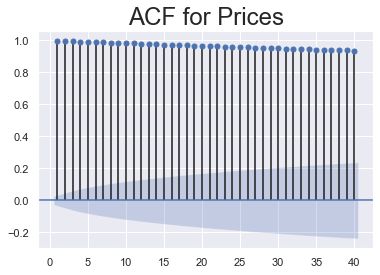

In [24]:
sgt.plot_acf(df.market_value, lags = 40, zero = False)
plt.title("ACF for Prices", size = 24)
plt.show()

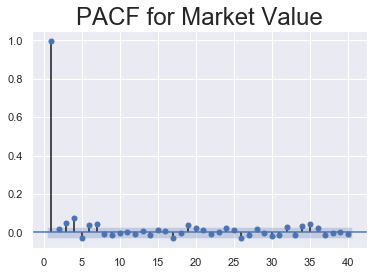

In [25]:
sgt.plot_pacf(df.market_value, lags = 40, zero = False, method = ('ols'))
plt.title("PACF for Market Value", size = 24)
plt.show()

## ARMA(1,1) for Prices

In [26]:
model_ar_1_ma_1 = ARMA(df.market_value, order = (1,1))
results_ar_1_ma_1 = model_ar_1_ma_1.fit()
results_ar_1_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(1, 1)   Log Likelihood              -27621.789
Method:                       css-mle   S.D. of innovations             59.248
Date:                Sat, 25 Apr 2020   AIC                          55251.579
Time:                        19:05:26   BIC                          55277.664
Sample:                    01-07-1994   HQIC                         55260.719
                         - 04-05-2013                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5089.6411    496.778     10.245      0.000    4115.974    6063.309
ar.L1.market_value     0.9985      0.001   1323.192      0.000       0.997       1.000
ma.L1.market_value    -0.0190      0.015     -1.274      0.203      -0.048       0.010
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0015           +0.0000j            1.0015            0.0000
MA.1           52.5192           +0.0000j           52.5192            0.0000
-----------------------------------------------------------------------------
"""

In [27]:
df['res_ar_1_ma_1'] = results_ar_1_ma_1.resid

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


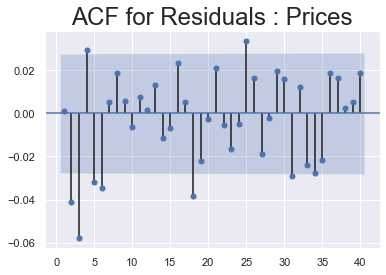

In [28]:
sgt.plot_acf(df.res_ar_1_ma_1, lags = 40, zero = False)
plt.title("ACF for Residuals : Prices",  size = 24)
plt.show()

### Since, 5 out of the first 6 lags are significant, we must tr and fit an ARMA(6,6) model

## ARMA(6,6) for Prices

In [29]:
model_ar_6_ma_6 = ARMA(df.market_value, order = (6,6))
results_ar_6_ma_6 = model_ar_6_ma_6.fit(start_ar_lags = 11)
results_ar_6_ma_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(6, 6)   Log Likelihood              -27587.932
Method:                       css-mle   S.D. of innovations             58.849
Date:                Sat, 25 Apr 2020   AIC                          55203.864
Time:                        19:05:33   BIC                          55295.164
Sample:                    01-07-1994   HQIC                         55235.856
                         - 04-05-2013                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5089.6476    568.476      8.953      0.000    3975.456    6203.839
ar.L1.market_value     1.9268      0.032     59.877      0.000       1.864       1.990
ar.L2.market_value    -1.7347      0.040    -43.287      0.000      -1.813      -1.656
ar.L3.market_value     1.2665      0.035     36.641      0.000       1.199       1.334
ar.L4.market_value    -0.2363      0.158     -1.494      0.135      -0.546       0.074
ar.L5.market_value    -0.4066      0.165     -2.459      0.014      -0.731      -0.083
ar.L6.market_value     0.1839      0.049      3.770      0.000       0.088       0.280
ma.L1.market_value    -0.9479      0.035    -27.009      0.000      -1.017      -0.879
ma.L2.market_value     0.7795      0.032     24.112      0.000       0.716       0.843
ma.L3.market_value    -0.5078      0.031    -16.291      0.000      -0.569      -0.447
ma.L4.market_value    -0.1566      0.159     -0.986      0.324      -0.468       0.155
ma.L5.market_value     0.0951      0.057      1.680      0.093      -0.016       0.206
ma.L6.market_value     0.0670      0.024      2.799      0.005       0.020       0.114
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.0857           -1.0502j            1.0537           -0.2370
AR.2            0.0857           +1.0502j            1.0537            0.2370
AR.3           -2.0245           -0.0000j            2.0245           -0.5000
AR.4            1.0011           -0.0000j            1.0011           -0.0000
AR.5            1.5315           -0.2669j            1.5546           -0.0275
AR.6            1.5315           +0.2669j            1.5546            0.0275
MA.1            0.1028           -1.0611j            1.0661           -0.2346
MA.2            0.1028           +1.0611j            1.0661            0.2346
MA.3            1.3629           -0.2795j            1.3912           -0.0322
MA.4            1.3629           +0.2795j            1.3912            0.0322
MA.5           -2.1760           -1.4324j            2.6051           -0.4073
MA.6           -2.1760           +1.4324j            2.6051            0.4073
-----------------------------------------------------------------------------
"""

### After trial and error we have found that ARMA(5,6) and ARMA(6,1) are the models with significant coefficients

## ARMA (5,6) for Prices

In [30]:
model_ar_5_ma_6 = ARMA(df.market_value, order = (5,6))
results_ar_5_ma_6 = model_ar_5_ma_6.fit(start_ar_lags = 7)
results_ar_5_ma_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(5, 6)   Log Likelihood              -27587.863
Method:                       css-mle   S.D. of innovations             58.849
Date:                Sat, 25 Apr 2020   AIC                          55201.726
Time:                        19:27:29   BIC                          55286.504
Sample:                    01-07-1994   HQIC                         55231.433
                         - 04-05-2013                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5089.6470    580.913      8.761      0.000    3951.079    6228.215
ar.L1.market_value     1.3585      0.178      7.650      0.000       1.010       1.707
ar.L2.market_value    -1.1290      0.237     -4.754      0.000      -1.594      -0.664
ar.L3.market_value     0.9148      0.229      3.995      0.000       0.466       1.364
ar.L4.market_value     0.0159      0.204      0.078      0.938      -0.384       0.416
ar.L5.market_value    -0.1613      0.119     -1.351      0.177      -0.395       0.073
ma.L1.market_value    -0.3796      0.178     -2.132      0.033      -0.729      -0.031
ma.L2.market_value     0.7294      0.125      5.824      0.000       0.484       0.975
ma.L3.market_value    -0.2198      0.153     -1.437      0.151      -0.520       0.080
ma.L4.market_value    -0.1387      0.114     -1.215      0.225      -0.363       0.085
ma.L5.market_value    -0.0879      0.017     -5.325      0.000      -0.120      -0.056
ma.L6.market_value     0.0265      0.024      1.129      0.259      -0.020       0.073
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.0917           -1.0418j            1.0458           -0.2360
AR.2            0.0917           +1.0418j            1.0458            0.2360
AR.3            1.0010           -0.0000j            1.0010           -0.0000
AR.4            1.8977           -0.0000j            1.8977           -0.0000
AR.5           -2.9839           -0.0000j            2.9839           -0.5000
MA.1            0.1071           -1.0487j            1.0542           -0.2338
MA.2            0.1071           +1.0487j            1.0542            0.2338
MA.3           -1.5353           -1.5156j            2.1574           -0.3760
MA.4           -1.5353           +1.5156j            2.1574            0.3760
MA.5            1.5918           -0.0000j            1.5918           -0.0000
MA.6            4.5776           -0.0000j            4.5776           -0.0000
-----------------------------------------------------------------------------
"""

In [31]:
model_ar_6_ma_1 = ARMA(df.market_value, order = (6,1))
results_ar_6_ma_1 = model_ar_6_ma_1.fit(start_ar_lags = 7)
results_ar_6_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(6, 1)   Log Likelihood              -27594.195
Method:                       css-mle   S.D. of innovations             58.923
Date:                Sat, 25 Apr 2020   AIC                          55206.389
Time:                        19:28:03   BIC                          55265.082
Sample:                    01-07-1994   HQIC                         55226.956
                         - 04-05-2013                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5089.6424    586.464      8.679      0.000    3940.193    6239.091
ar.L1.market_value     1.3921      0.058     23.923      0.000       1.278       1.506
ar.L2.market_value    -0.4369      0.059     -7.398      0.000      -0.553      -0.321
ar.L3.market_value    -0.0101      0.025     -0.409      0.683      -0.059       0.038
ar.L4.market_value     0.1126      0.025      4.527      0.000       0.064       0.161
ar.L5.market_value    -0.1157      0.025     -4.717      0.000      -0.164      -0.068
ar.L6.market_value     0.0573      0.014      4.067      0.000       0.030       0.085
ma.L1.market_value    -0.4126      0.060     -6.923      0.000      -0.529      -0.296
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0010           -0.0000j            1.0010           -0.0000
AR.2           -1.7608           -0.0000j            1.7608           -0.5000
AR.3           -0.0803           -1.8407j            1.8424           -0.2569
AR.4           -0.0803           +1.8407j            1.8424            0.2569
AR.5            1.4694           -0.8692j            1.7072           -0.0850
AR.6            1.4694           +0.8692j            1.7072            0.0850
MA.1            2.4235           +0.0000j            2.4235            0.0000
-----------------------------------------------------------------------------
"""

In [33]:
print("ARMA(5,6) ", "\tLLR : ", results_ar_5_ma_6.llf, "\tAIC : ", results_ar_5_ma_6.aic)
print("ARMA(6,1) ", "\tLLR : ", results_ar_6_ma_1.llf, "\tAIC : ", results_ar_6_ma_1.aic)

ARMA(5,6)  	LLR :  -27587.86294791494 	AIC :  55201.72589582988
ARMA(6,1)  	LLR :  -27594.194571068485 	AIC :  55206.38914213697
